In [1]:
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("./data.csv",converters={'CustomerID':str})
# 轉成年月
df['date']=df.InvoiceDate.astype(np.str).str.slice(0,8).str.replace('-','')
df['date'] = pd.to_numeric(df['date'], errors='coerce')

In [3]:
df.head()

,CustomerID,InvoiceNo,InvoiceDate,Total_Price,date
0,17850,536365.0,2010-12-01 08:26:00,15.30,201012
1,17850,536365.0,2010-12-01 08:26:00,20.34,201012
2,17850,536365.0,2010-12-01 08:26:00,22.00,201012
3,17850,536365.0,2010-12-01 08:26:00,20.34,201012
4,17850,536365.0,2010-12-01 08:26:00,20.34,201012


### 計算最近購買日期(Recency)

In [4]:
def f(row):
    if row['date'] > 201110:
        val = 5
    elif row['date'] <= 201110 and row['date'] > 201108:
        val = 4
    elif row['date'] <= 201108 and row['date'] > 201106:
        val = 3
    elif row['date'] <= 201106 and row['date'] > 201104:
        val = 2
    else:
        val = 1
    return val
df_recency=df[['CustomerID','date']].drop_duplicates()
df_recency['Recency_Flag'] = df_recency.apply(f, axis=1)
df_recency = df_recency.groupby('CustomerID',as_index=False)['Recency_Flag'].max()

In [5]:
df_recency.head(10)

,CustomerID,Recency_Flag
0,12346,1
1,12747,5
2,12748,5
3,12749,5
4,12820,5
5,12821,2
6,12822,4
7,12823,4
8,12824,4
9,12826,5


### 計算購買頻率(Frequency)

In [6]:
Cust_freq=df[['InvoiceNo','CustomerID']].drop_duplicates()
#Calculating the count of unique purchase for each customer
Cust_freq_count=Cust_freq.groupby(['CustomerID'])['InvoiceNo'].aggregate('count').\
reset_index().sort_values('InvoiceNo', ascending=False, axis=0)
unique_invoice=Cust_freq_count[['InvoiceNo']].drop_duplicates()
# Dividing in 5 equal parts
unique_invoice['Freqency_Band'] = pd.qcut(unique_invoice['InvoiceNo'], 5)
unique_invoice=unique_invoice[['Freqency_Band']].drop_duplicates()
unique_invoice

,Freqency_Band
2,"(50.6, 210.0]"
625,"(34.2, 50.6]"
3297,"(22.8, 34.2]"
2531,"(11.4, 22.8]"
2854,"(-0.001, 11.4]"


In [7]:
def f2(row):
    if row['InvoiceNo'] <= 11:
        val = 1
    elif row['InvoiceNo'] <= 22:
        val = 2
    elif row['InvoiceNo'] <= 34:
        val = 3
    elif row['InvoiceNo'] <= 50:
        val = 4
    else:
        val = 5
    return val
    
Cust_freq_count['Freq_Flag'] = Cust_freq_count.apply(f2, axis=1)

### 計算購買金額(Monetary)

In [8]:
#Calculating the Sum of total monetary purchase for each customer
Cust_monetary = df.groupby(['CustomerID'])['Total_Price'].aggregate('sum').\
reset_index().sort_values('Total_Price', ascending=False)
# splitting Total price in 5 parts
unique_price=Cust_monetary[['Total_Price']].drop_duplicates()
unique_price=unique_price[unique_price['Total_Price'] > 0]
unique_price['monetary_Band'] = pd.qcut(unique_price['Total_Price'], 5)
unique_price=unique_price[['monetary_Band']].drop_duplicates()
unique_price

,monetary_Band
3811,"(1931.42, 256438.49]"
1533,"(891.12, 1931.42]"
504,"(463.38, 891.12]"
1188,"(243.22, 463.38]"
1305,"(-0.00099999999999289, 243.22]"


In [9]:
def f3(row):
    if row['Total_Price'] <= 243:
        val = 1
    elif row['Total_Price'] > 243 and row['Total_Price'] <= 463:
        val = 2
    elif row['Total_Price'] > 463 and row['Total_Price'] <= 892:
        val = 3
    elif row['Total_Price'] > 892 and row['Total_Price'] <= 1932:
        val = 4
    else:
        val = 5
    return val
Cust_monetary['Monetary_Flag'] = Cust_monetary.apply(f3, axis=1)

### 合併 RFM 欄位

In [10]:
Cust_All=pd.merge(df_recency,Cust_freq_count[['CustomerID','Freq_Flag']], on=['CustomerID'],how='left')
Cust_All=pd.merge(Cust_All,Cust_monetary[['CustomerID','Monetary_Flag']], on=['CustomerID'],how='left')
Cust_All.head(10)

,CustomerID,Recency_Flag,Freq_Flag,Monetary_Flag
0,12346,1,1,1
1,12747,5,1,5
2,12748,5,5,5
3,12749,5,1,5
4,12820,5,1,4
5,12821,2,1,1
6,12822,4,1,4
7,12823,4,1,4
8,12824,4,1,2
9,12826,5,1,4


### 使用 K means 分群

In [11]:
Cust_All.drop(Cust_All.columns[0], axis=1, inplace=True)

In [12]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(Cust_All)
    wcss.append(kmeans.inertia_)


### 損失函數作圖

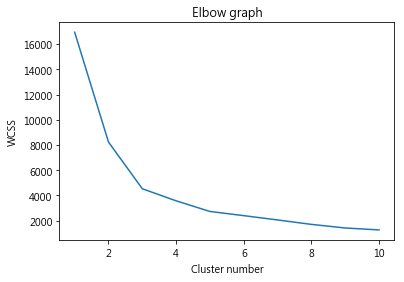

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt 

plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

## 決定分為4集群(Cluster)

In [14]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
Cust_All['clusters'] = kmeans.fit_predict(Cust_All)
Cust_All.tail(10)

,Recency_Flag,Freq_Flag,Monetary_Flag,clusters
3940,5,1,1,2
3941,5,1,1,2
3942,5,1,2,2
3943,4,1,1,2
3944,4,1,1,2
3945,1,1,1,1
3946,2,1,1,1
3947,5,1,1,2
3948,5,2,5,3
3949,4,1,4,0


## VIP 是第四集群(Cluster)

In [15]:
round(pd.DataFrame(kmeans.cluster_centers_),2)

,0,1,2
0,4.45,1.00,3.53
1,1.35,1.00,1.89
2,4.23,1.00,1.53
3,4.72,1.48,4.99


In [16]:
Cust_All[Cust_All.clusters== 3]

,Recency_Flag,Freq_Flag,Monetary_Flag,clusters
1,5,1,5,3
2,5,5,5,3
3,5,1,5,3
13,5,1,5,3
18,4,1,5,3
21,5,2,5,3
22,3,1,5,3
23,5,3,5,3
35,5,1,5,3
39,5,1,5,3
